In [4]:
%matplotlib inline
%pylab inline

import math
import numpy as np
from numpy import linalg as lg
import matplotlib.pyplot as plt

# some constants


Populating the interactive namespace from numpy and matplotlib


### Кривая Коха
Кривая Коха является типичным геометрическим фракталом. Процесс её построения выглядит следующим образом: берём единичный отрезок, разделяем на три равные части и заменяем средний интервал равносторонним треугольником без этого сегмента. В результате образуется ломаная, состоящая из четырёх звеньев длины 1/3. На следующем шаге повторяем операцию для каждого из четырёх получившихся звеньев и т. д… Предельная кривая и есть кривая Коха.

In [5]:
def koch_iteration(points):
    if len(points) < 2:
        return None
    
    def rotate(v, angle):
        return (v[0]*math.cos(angle) - v[1]*math.sin(angle), 
               v[0]*math.sin(angle) + v[1]*math.cos(angle))
    
    new_points = []
    length = 0.0
    for i in range(len(points)-1):        
        v = (points[i+1][0] - points[i][0], points[i+1][1] - points[i][1])
        u = (float(v[0])/3., float(v[1])/3.)
        w = rotate(u, math.pi/3.)
        
        new_points.append((points[i][0], points[i][1]))
        new_points.append((points[i][0] + u[0], points[i][1] + u[1]))
        new_points.append((points[i][0] + u[0] + w[0], points[i][1] + u[1] + w[1]))
        new_points.append((points[i][0] + 2.*u[0], points[i][1] + 2.*u[1]))
        length += 4.0 * math.sqrt(u[0]**2 + u[1]**2)
        
    new_points.append((points[len(points)-1][0], points[len(points)-1][1]))
    return new_points, length

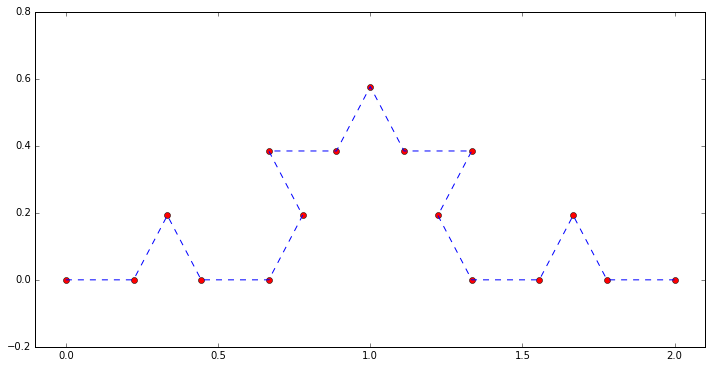

In [6]:
pylab.rcParams['figure.figsize'] = (12, 6)

points = [(0, 0), (2, 0)]

points, length_1 = koch_iteration(points)
points, length_2 = koch_iteration(points)
#points, length_3 = koch_iteration(points)

x = [points[i][0] for i in range(len(points))]
y = [points[i][1] for i in range(len(points))]

plt.axis([-0.1, 2.1, -0.2, 0.8])
plt.plot(x, y, 'ro')
plt.plot(x, y, '--')
plt.show()

### Полином найлучшего среднеквадратичного приближения
Задача построение полинома наперёд заданного степеня $$P_n(x) = \sum_{k=0}^n{c_kx^k},$$ для которого значение $$J = \sqrt{\int_a^b{(f(x)-P(x))^2}} \rightarrow min$$
сводится к поиску коеффициентов $c_k$ через следующую систему:
$$\left( \begin{matrix}
    (\phi_0, \phi_0) & (\phi_0, \phi_1) & \dots  & (\phi_0, \phi_n) \\
    (\phi_1, \phi_0) & (\phi_1, \phi_1) & \dots  & (\phi_1, \phi_n) \\
    \vdots           & \vdots           & \ddots & \vdots           \\
    (\phi_n, \phi_0) & (\phi_n, \phi_1) & \dots  & (\phi_n, \phi_n) \\
\end{matrix} \right)
\left( \begin{matrix}
    c_0 \\
    c_1 \\
    \vdots \\
    c_n \\
\end{matrix} \right)
=
\left( \begin{matrix}
    (f, \phi_0) \\
    (f, \phi_1) \\
    \vdots      \\
    (f, \phi_n) \\
\end{matrix} \right)
$$
где $\phi_i(x)= x^i$ - базисные функции. 
Для конечного набора точек $\{(x_1, y_1), (x_2, y_2) \dots (x_m, y_m)\},$ справедливо:  
$$(\phi_i, \phi_j) = \sum_{k=0}^m{x_k^i x_k^j}\\ (f, \phi_i) = \sum_{k=0}^m{y_k x_k^i}$$

In [7]:
def make_system(x, y, basis):
    A = [[0 for j in range(basis)] for i in range(basis)]
    b = [0 for i in range(basis)]
    
    for i in range(basis):
        for j in range(basis):    
            for k in range(len(x)):
                A[i][j] += x[k]**i * x[k]**j
        for k in range(len(y)):
            b[i] += y[k] * x[k]**i
        
    return A, b

0.00000x^7 +-2.80545x^6 +16.83269x^5 +-37.30826x^4 +37.01513x^3 +-15.82361x^2 +2.50412x^1 +-0.00834x^0 +


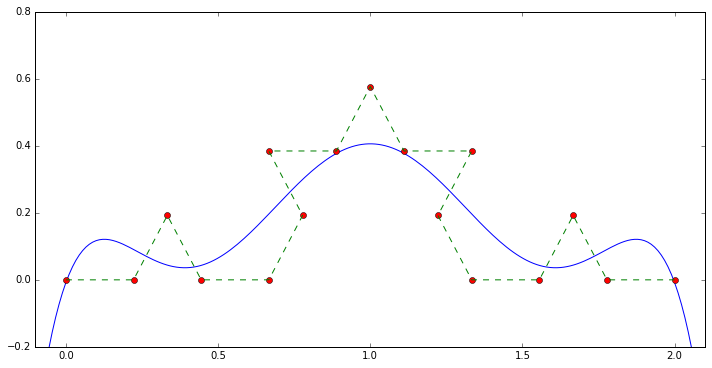

In [8]:
pylab.rcParams['figure.figsize'] = (12, 6)

A, b = make_system(x, y, 8)
A = np.array(A)
b = np.array(b)

c = lg.solve(A, b)[::-1]

cs = ""
for ccc in range(len(c)):
    cs += "%.5f" % c[ccc]
    cs += "x^%d +" % (len(c) - ccc - 1)
print (cs)

P = np.poly1d(c)

t = np.linspace(-0.1, 2.1, num=200)
plt.axis([-0.1, 2.1, -0.2, 0.8])
plt.plot(t, P(t))
plt.plot(x, y, 'ro')
plt.plot(x, y, '--')

plt.show()

### Длина полиномиальной кривой
Длина кривой графика полинома $P_n(x)$ для $x \in [a, b]$ можно вычислить по следующей формуле:
$$L = \int_a^b \sqrt{1 + \left( \dfrac{\partial P_n}{\partial x} \right)^2}dx$$

In [9]:
def polylen(P, a, b, num=100):
    dP = np.polyder(P)
    I2 = np.polyadd(np.poly1d([1.0]), np.polymul(dP, dP))
    
    step = float(b - a)/float(num)
    
    S = 0.0
    for i in range(num):
        left = float(a) + float(i)*step
        right = left = float(a) + float(i)*step + step
        
        h = math.sqrt((I2(left) + I2(right))/2.0)
        S += step * h

    return S

In [10]:
print("Длина полиномиальной кривой:", polylen(P, 0, 2))
print("Длина кривой Коха 1-го порядка:", length_1)
print("Длина кривой Коха 2-го порядка:", length_2)
print("Длина кривой Коха 3-го порядка:", length_3)

Длина полиномиальной кривой: 2.408532292853658
Длина кривой Коха 1-го порядка: 2.6666666666666665
Длина кривой Коха 2-го порядка: 3.5555555555555554


NameError: name 'length_3' is not defined

0.09143x^2 +-0.98743x^1 +1.49743x^0 +


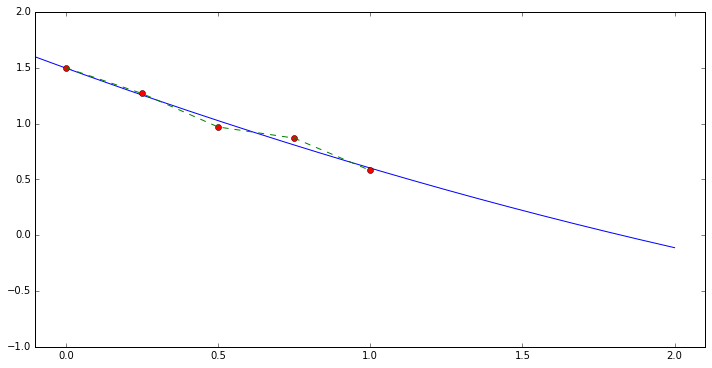

In [16]:
x = [0.0, 0.25, 0.5, 0.75, 1.0]
y = [1.5, 1.27, 0.97, 0.87, 0.58]

A, b = make_system(x, y, 3)
A = np.array(A)
b = np.array(b)

c = lg.solve(A, b)[::-1]

cs = ""
for ccc in range(len(c)):
    cs += "%.5f" % c[ccc]
    cs += "x^%d +" % (len(c) - ccc - 1)
print (cs)

P = np.poly1d(c)

t = np.linspace(-1, 2, num=200)
plt.axis([-0.1, 2.1, -1, 2])
plt.plot(t, P(t))
plt.plot(x, y, 'ro')
plt.plot(x, y, '--')

plt.show()